# Homework 06 - Trees

In [69]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import xgboost as xgb

%matplotlib inline

## Preparing the Dataset

Preparation:
1. Remove the student_id column.
2. Fill missing values with zeros.
3. Do train/validation/test split with 60%/20%/20% distribution.
4. Use the train_test_split function and set the random_state parameter to 1.
5. Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [70]:
url = 'https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv'
df = pd.read_csv(url)
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [71]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [72]:
df.drop(columns=['student_id'], inplace=True)

In [73]:
df.isna().sum()

jamb_score                        0
study_hours_per_week              0
attendance_rate                   0
teacher_quality                   0
distance_to_school                0
school_type                       0
school_location                   0
extra_tutorials                   0
access_to_learning_materials      0
parent_involvement                0
it_knowledge                      0
age                               0
gender                            0
socioeconomic_status              0
parent_education_level          891
assignments_completed             0
dtype: int64

In [74]:
df.fillna(0, inplace=True)

In [75]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)

In [76]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [77]:
y_train = df_train.jamb_score.astype('int')
y_val = df_val.jamb_score.astype('int')
y_test = df_test.jamb_score.astype('int')

In [78]:
df_train.drop(columns=['jamb_score'], inplace=True)
df_val.drop(columns=['jamb_score'], inplace=True)
df_test.drop(columns=['jamb_score'], inplace=True)

In [79]:
dv = DictVectorizer(sparse=False)

## Question 1

Let's train a decision tree regressor to predict the jamb_score variable.
- Train a model with max_depth=1.

Which feature is used for splitting the data?
1. study_hours_per_week <-
2. attendance_rate
3. teacher_quality
4. distance_to_school

In [80]:
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [81]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [82]:
feature_names = dv.get_feature_names_out()
feature_importance = dt.tree_.feature[0]
split_feature = feature_names[feature_importance]

In [87]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- study_hours_per_week <= 18.50
|   |--- value: [156.06]
|--- study_hours_per_week >  18.50
|   |--- value: [188.77]



In [86]:
print(f'The feature used for splitting the data is: {split_feature}')

The feature used for splitting the data is: study_hours_per_week


## Question 2
Train a random forest regressor with these parameters:
- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on the validation data?
1. 22.13
2. 42.13 <-
3. 62.13
4. 82.12

In [89]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'RMSE on the validation set is: {rmse:.2f}')

RMSE on the validation set is: 41.61


## Question 3

Now let's experiment with the n_estimators parameter
- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.
1. 10 <-
2. 25
3. 80
4. 200

In [95]:
rmse_values = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_values.append((n, rmse))

for n, rmse in rmse_values:
    print(f'n_estimators={n}: RMSE={rmse:.3f}')

n_estimators=10: RMSE=41.609
n_estimators=20: RMSE=40.937
n_estimators=30: RMSE=40.404
n_estimators=40: RMSE=40.251
n_estimators=50: RMSE=40.326
n_estimators=60: RMSE=40.284
n_estimators=70: RMSE=40.215
n_estimators=80: RMSE=40.223
n_estimators=90: RMSE=40.296
n_estimators=100: RMSE=40.349
n_estimators=110: RMSE=40.326
n_estimators=120: RMSE=40.306
n_estimators=130: RMSE=40.334
n_estimators=140: RMSE=40.321
n_estimators=150: RMSE=40.299
n_estimators=160: RMSE=40.323
n_estimators=170: RMSE=40.329
n_estimators=180: RMSE=40.354
n_estimators=190: RMSE=40.366
n_estimators=200: RMSE=40.378


In [92]:
df_scores = pd.DataFrame(rmse_values, columns=['n', 'rmse'])

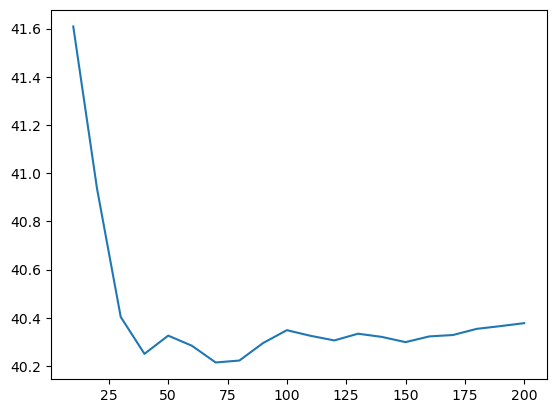

In [93]:
plt.plot(df_scores.n, df_scores.rmse)
plt.show()

## Question 4

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values,
    - try different values of n_estimators from 10 till 200 (with step 10)
    - calculate the mean RMSE
- Fix the random seed: random_state=1

What's the best max_depth, using the mean RMSE?
1. 10
2. 15
3. 20
4. 25

In [ ]:
mean_rmse_values = []

max_depth_values = [10, 15, 20, 25]

for max_depth in max_depth_values:
    rmse_per_depth = []
    
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=max_depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_val)
        
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_per_depth.append(rmse)
    
    mean_rmse = np.mean(rmse_per_depth)
    mean_rmse_values.append((max_depth, mean_rmse))

In [101]:
columns = ['max_depth', 'mean_rmse']
df_scores = pd.DataFrame(mean_rmse_values, columns=columns)
df_scores

,max_depth,mean_rmse
0,10,39.907944
1,15,40.299001
2,20,40.289074
3,25,40.407984


## Question 5

We can extract feature importance information from tree-based models. At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models. In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

### For this homework question, we'll find the most important feature:
- Train the model with these parameters:
    - n_estimators=10,
    - max_depth=20,
    - random_state=1,
    - n_jobs=-1 (optional)
- Get the feature importance information from this model

What's the most important feature (among these 4)?
1. study_hours_per_week <-
2. attendance_rate
3. distance_to_school
4. teacher_quality

In [111]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = dv.feature_names_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

selected_features = ['study_hours_per_week', 'attendance_rate', 'distance_to_school', 'teacher_quality']
filtered_importance_df = importance_df[importance_df['feature'].isin(selected_features)]
filtered_importance_df = filtered_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
filtered_importance_df

,feature,importance
0,study_hours_per_week,0.239245
1,attendance_rate,0.151180
2,distance_to_school,0.141347
3,teacher_quality,0.080320


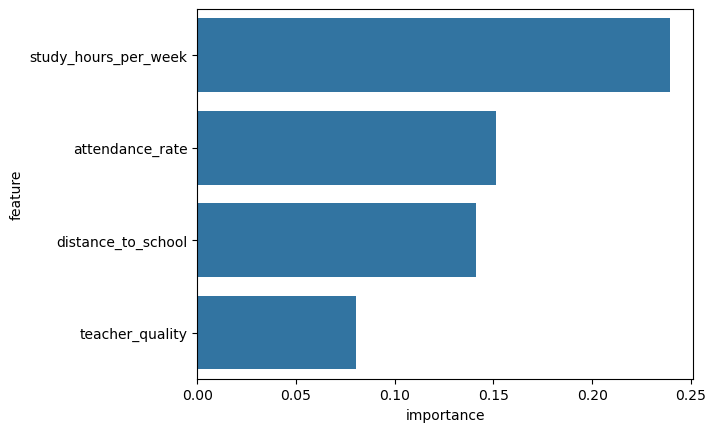

In [114]:
sns.barplot(x='importance', y='feature', data=filtered_importance_df)
plt.show()

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

1. 0.3
2. 0.1 <-
3. Both give equal value

In [118]:
# create DMatrix for train and validation
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# create a watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [120]:
# parameters for model 1 - eta: 0.3
xgb_params1 = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# model 1 - eta: 0.3
model1 = xgb.train(xgb_params1, dtrain, num_boost_round=100, evals=watchlist)
y_pred1 = model1.predict(dval)
rmse1 = np.sqrt(mean_squared_error(y_val, y_pred1))
print(f"RMSE with eta=0.3: {rmse1:.3f}")

[0]	train-rmse:42.91051	val-rmse:44.64705
[1]	train-rmse:40.11270	val-rmse:42.58787
[2]	train-rmse:38.22082	val-rmse:41.29400


[3]	train-rmse:36.84288	val-rmse:40.86943
[4]	train-rmse:35.61478	val-rmse:40.40802
[5]	train-rmse:34.75100	val-rmse:40.18339
[6]	train-rmse:34.01920	val-rmse:40.01861
[7]	train-rmse:33.57026	val-rmse:39.83977
[8]	train-rmse:33.06957	val-rmse:39.77520
[9]	train-rmse:32.53383	val-rmse:39.67272
[10]	train-rmse:31.99488	val-rmse:39.86428
[11]	train-rmse:31.63632	val-rmse:39.94614
[12]	train-rmse:31.06808	val-rmse:40.22402
[13]	train-rmse:30.66612	val-rmse:40.21996
[14]	train-rmse:30.22377	val-rmse:40.23733
[15]	train-rmse:29.89650	val-rmse:40.13093
[16]	train-rmse:29.65509	val-rmse:40.23658
[17]	train-rmse:29.39022	val-rmse:40.26492
[18]	train-rmse:28.87405	val-rmse:40.34034
[19]	train-rmse:28.49540	val-rmse:40.30164
[20]	train-rmse:28.09664	val-rmse:40.26037
[21]	train-rmse:27.63299	val-rmse:40.23921
[22]	train-rmse:27.20857	val-rmse:40.28724
[23]	train-rmse:26.73463	val-rmse:40.40341
[24]	train-rmse:26.34008	val-rmse:40.44099
[25]	train-rmse:26.07609	val-rmse:40.48417
[26]	train-rmse:25

In [121]:
# parameters for model 2 - eta: 0.1
xgb_params2 = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Train for 100 rounds
model2 = xgb.train(xgb_params2, dtrain, num_boost_round=100, evals=watchlist)

y_pred2 = model2.predict(dval)
rmse2 = np.sqrt(mean_squared_error(y_val, y_pred2))
print(f"RMSE with eta=0.1: {rmse2:.3f}")

[0]	train-rmse:45.63274	val-rmse:46.87538
[1]	train-rmse:44.30763	val-rmse:45.80280
[2]	train-rmse:43.11133	val-rmse:44.85854
[3]	train-rmse:42.08625	val-rmse:44.11457
[4]	train-rmse:41.14822	val-rmse:43.37733
[5]	train-rmse:40.32728	val-rmse:42.76087
[6]	train-rmse:39.62377	val-rmse:42.30957
[7]	train-rmse:39.00484	val-rmse:41.97211
[8]	train-rmse:38.38784	val-rmse:41.53205
[9]	train-rmse:37.88972	val-rmse:41.26639
[10]	train-rmse:37.40591	val-rmse:41.05780
[11]	train-rmse:36.98085	val-rmse:40.81897
[12]	train-rmse:36.54822	val-rmse:40.65726
[13]	train-rmse:36.19586	val-rmse:40.53495
[14]	train-rmse:35.85449	val-rmse:40.33345
[15]	train-rmse:35.48487	val-rmse:40.21406
[16]	train-rmse:35.20274	val-rmse:40.14489
[17]	train-rmse:34.92670	val-rmse:40.10178
[18]	train-rmse:34.64257	val-rmse:40.02224
[19]	train-rmse:34.32961	val-rmse:39.99403
[20]	train-rmse:34.08557	val-rmse:39.97288
[21]	train-rmse:33.85198	val-rmse:39.91166
[22]	train-rmse:33.66574	val-rmse:39.90718
[23]	train-rmse:33.44